# Лабораторная работа №3 RNN, GRU, LSTM

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from dllib.model import RNN, GRU, LSTM
from dllib.utils import (
    create_sequences,
    device,
    mse,
    r2_score,
    rmse,
)

device.seed_everything(42)

xp = device.xp

## Константы

In [3]:
SEQUENCE_LENGTH = 20
HIDDEN_SIZE = 64
EPOCHS = 10
BATCH_SIZE = 32

## Загрузка данных и предобработка данных

In [4]:
steel = fetch_ucirepo(id=851)
X_df = steel.data.features
y_series = steel.data.features["Usage_kWh"]
X_df = X_df.drop(columns=["Usage_kWh"])
print(f"Форма данных X: {X_df.shape}")
print(f"Форма целевой переменной y: {y_series.shape}")

Форма данных X: (35040, 8)
Форма целевой переменной y: (35040,)


In [5]:
categorical_cols = X_df.select_dtypes(include=['object']).columns.tolist()
print("Категориальные признаки:", categorical_cols)

Категориальные признаки: ['WeekStatus', 'Day_of_week']


In [6]:
X_df = pd.get_dummies(X_df, columns=categorical_cols, drop_first=True)
X_df.describe()

,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


In [7]:
num_cols = X_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
mu_X = X_df[num_cols].mean().values.astype(np.float32)
sigma_X = X_df[num_cols].std().values.astype(np.float32)
X_df[num_cols] = (X_df[num_cols] - mu_X) / sigma_X
mu_y = y_series.mean().astype(np.float32)
sigma_y = y_series.std().astype(np.float32)
y_norm = ((y_series - mu_y) / sigma_y).values.astype(np.float32)

In [8]:
X_seq, y_seq = create_sequences(X_df.values.astype(np.float32), y_norm, SEQUENCE_LENGTH)
print(f"Форма последовательностей X: {X_seq.shape}")
print(f"Форма целевых значений y: {y_seq.shape}")

Форма последовательностей X: (35020, 20, 13)
Форма целевых значений y: (35020,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (28016, 20, 13), Test: (7004, 20, 13)


## Обучение моделей

### Модели

In [10]:
models = {
    "RNN": RNN(input_size=X_seq.shape[2], hidden_size=HIDDEN_SIZE, output_size=1),
    "GRU": GRU(input_size=X_seq.shape[2], hidden_size=HIDDEN_SIZE, output_size=1),
    "LSTM": LSTM(input_size=X_seq.shape[2], hidden_size=HIDDEN_SIZE, output_size=1),
}

In [11]:
results = {}
for name, model in models.items():
    print(f"\nОбучение {name}...")
    history = model.train(X_train, y_train, X_test, y_test, epochs=EPOCHS, batch_size=BATCH_SIZE)
    results[name] = {"model": model, "history": history}


Обучение RNN...
Epoch 1/10 | Train Loss: 0.37192 | Test Loss: 0.16393
Epoch 2/10 | Train Loss: 0.17531 | Test Loss: 0.12932
Epoch 3/10 | Train Loss: 0.15391 | Test Loss: 0.11950
Epoch 4/10 | Train Loss: 0.14532 | Test Loss: 0.11803
Epoch 5/10 | Train Loss: 0.13967 | Test Loss: 0.10879
Epoch 6/10 | Train Loss: 0.13477 | Test Loss: 0.10426
Epoch 7/10 | Train Loss: 0.13040 | Test Loss: 0.10073
Epoch 8/10 | Train Loss: 0.12635 | Test Loss: 0.09902
Epoch 9/10 | Train Loss: 0.12323 | Test Loss: 0.09555
Epoch 10/10 | Train Loss: 0.12095 | Test Loss: 0.09312

Обучение GRU...
Epoch 1/10 | Train Loss: 0.62170 | Test Loss: 0.35581
Epoch 2/10 | Train Loss: 0.34673 | Test Loss: 0.25714
Epoch 3/10 | Train Loss: 0.25569 | Test Loss: 0.17344
Epoch 4/10 | Train Loss: 0.21485 | Test Loss: 0.14577
Epoch 5/10 | Train Loss: 0.18905 | Test Loss: 0.14002
Epoch 6/10 | Train Loss: 0.18060 | Test Loss: 0.13296
Epoch 7/10 | Train Loss: 0.17369 | Test Loss: 0.12703
Epoch 8/10 | Train Loss: 0.17023 | Test Loss: 0

## Оценка моделей

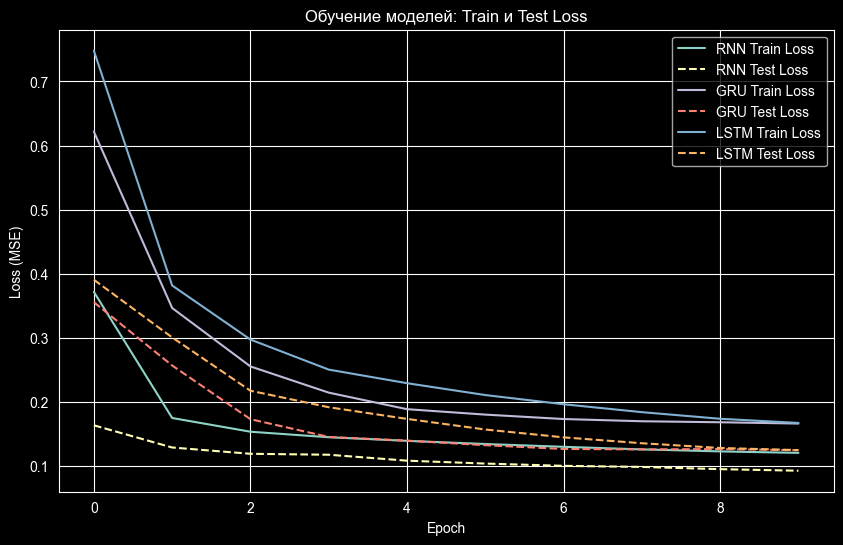

In [12]:
plt.figure(figsize=(10, 6))

for name, result in results.items():
    history = result["history"]
    plt.plot(history["train_loss"], label=f"{name} Train Loss", linestyle='-')
    plt.plot(history["test_loss"], label=f"{name} Test Loss", linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Обучение моделей: Train и Test Loss")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
final_results = {}

for name, result in results.items():
    model = result["model"]
    y_pred = model.forward(device.ensure_tensor(X_test))
    y_pred_cpu = device.to_cpu(y_pred).flatten()

    y_test_denorm = y_test * sigma_y + mu_y
    y_pred_denorm = y_pred_cpu * sigma_y + mu_y

    final_results[name] = {
        "MSE": mse(y_test_denorm, y_pred_denorm),
        "RMSE": rmse(y_test_denorm, y_pred_denorm),
        "R^2": r2_score(y_test_denorm, y_pred_denorm),
    }
final_results = pd.DataFrame(final_results)
print(final_results.T.to_string(float_format=lambda x: f"{x:.6f}"))

            MSE      RMSE      R^2
RNN  104.155334 10.205652 0.894198
GRU  139.890549 11.827534 0.857897
LSTM 140.086105 11.835797 0.857699


In [14]:
best_model = min(final_results.items(), key=lambda x: x[1]["MSE"])
print(f"Лучшая модель по MSE: {best_model[0]} (MSE = {best_model[1]['MSE']:.6f})")

best_r2 = max(final_results.items(), key=lambda x: x[1]["R^2"])
print(f"Лучшая модель по R^2: {best_r2[0]} (R^2 = {best_r2[1]['R^2']:.6f})")

Лучшая модель по MSE: RNN (MSE = 104.155334)
Лучшая модель по R^2: RNN (R^2 = 0.894198)
